In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import sys
sys.path.append("../..") # include base dir

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ju36gh4g because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
# Dataset is a mimic of the toy dataset presented in 
# "Independent Subspace Analysis for Unsupervised Learning of Disentangled Representations"
datafile = "icaData.npz"
if not os.path.exists(datafile):
    N = 100000
    trueLatents = np.random.standard_t(3.5, size=(N,3))
    W = np.array([[1              ,0              ],
                  [np.cos(np.pi/6),np.sin(np.pi/6)],
                  [np.cos(np.pi/3),np.sin(np.pi/3)]
                 ]).T
    dataset = (W @ trueLatents.T).T
    dataset = dataset[:,:,np.newaxis, np.newaxis]
    np.savez_compressed(datafile, dataset=dataset)
dataset = np.load(datafile)["dataset"]

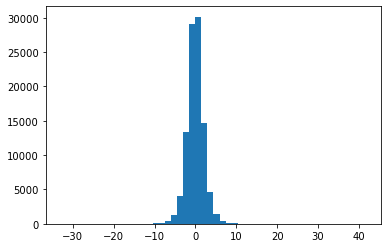

In [7]:
plt.hist(dataset[:,0,0,0],bins=50);

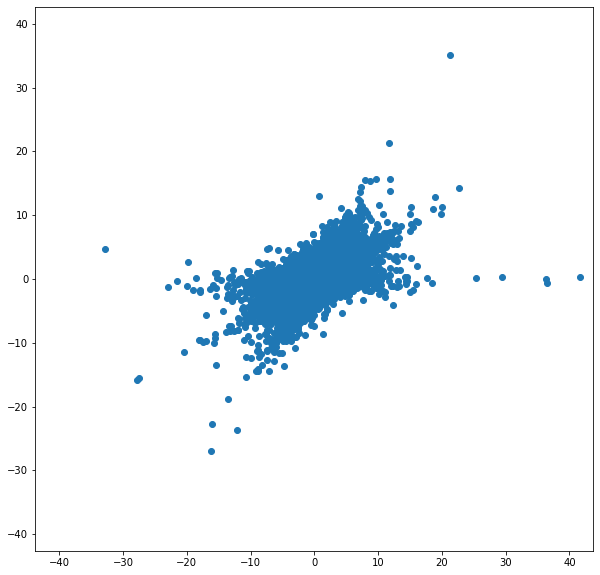

In [8]:
f = plt.figure(figsize=(10,10))
plt.scatter(dataset[:,0],dataset[:,1])
plt.axis("equal")
lim = np.max(np.abs(dataset)) * 1.05
plt.ylim((-lim,lim))
plt.xlim((-lim,lim));

In [9]:
from jlonevae_lib.architecture.vae import ConvVAE
from jlonevae_lib.train.jlonevae_trainer import JLOneVAETrainer
import datetime
import torch
import math

# define our convolutional network parameters
# see jlonevae_lib.architecture.vae.ConvVAE for how these parameters define the VAE network.
emb_conv_layers_channels = []
emb_conv_layers_strides = []
emb_conv_layers_kernel_sizes = []
emb_fc_layers_num_features = [10,10,10]
gen_conv_layers_channels = []
gen_conv_layers_kernel_sizes = []
gen_fc_layers_num_features = [10,10,2]
gen_first_im_side_len=1
gen_conv_layers_strides = []
im_channels = 2
im_side_len = 1
latent_dim=3
device="cpu"

model = ConvVAE(
         latent_dim = latent_dim,
         im_side_len = im_side_len,
         im_channels = im_channels,
         emb_conv_layers_channels = emb_conv_layers_channels,
         emb_conv_layers_strides = emb_conv_layers_strides,
         emb_conv_layers_kernel_sizes = emb_conv_layers_kernel_sizes,
         emb_fc_layers_num_features = emb_fc_layers_num_features,
         gen_fc_layers_num_features = gen_fc_layers_num_features,
         gen_first_im_side_len = gen_first_im_side_len,
         gen_conv_layers_channels = gen_conv_layers_channels,
         gen_conv_layers_strides = gen_conv_layers_strides,
         gen_conv_layers_kernel_sizes = gen_conv_layers_kernel_sizes
        ).to(device)

batch_size = 64
num_batches = 200000
run_beta = 1.0
run_gamma = 0.0
lr = 0.001
annealingBatches = 100000
#https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

488


In [67]:
modelDir = "trainedModels/%s/" % (datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
data_loader = torch.utils.data.DataLoader(dataset.astype(np.float32),batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
trainer = JLOneVAETrainer(model, data_loader,
  beta=run_beta, gamma=run_gamma,
  device=device, log_dir=modelDir, lr = lr,
  annealingBatches=annealingBatches)
print(len(dataset))
num_epochs = int(math.ceil(num_batches * batch_size/len(dataset)))
print(num_epochs)
for i in range(num_epochs):
    trainer.train()
# save a cached version of this model
save_conv_vae(trainer.model, os.path.join(trainer.log_dir,
"cache_batch_no%d" % trainer.num_batches_seen))

100000
128


KeyboardInterrupt: 